### Objective: To compute electrostatic potentials for MPK190 antibodies. 

Ha recently emailed a large tranch of MPK190 HIC data. I want to compute the electrostatic potentials for these antibodies, to increase training data. 

Featurization for this includes: 
1. Create mutant structures using parental pdb and mutation. This is using OpenMM. 
2. Compute descriptors given pdbs. 


#### Load some modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from shutil import copy
import matplotlib.pyplot as plt
import nglview as nv
from Bio.SeqUtils import seq3
from tqdm.notebook import tqdm
from pdbfixer import PDBFixer
from openmm.app import PDBFile
import numpy as np
import plotly.express as px
from developability.utils import ls, plot_correlogram
from developability.pipeline import run_processing_pipeline
from developability.pdb_tools import (extract_fv_from_pdb, extract_sequence_from_pdb,transform_mutant_tuple, transform_mutant_tuples, mutate_protein, generate_mutations_dict)

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

### Load some metadata

In [2]:
DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)

files = [f for f in ls(data_path) if f.name.endswith('csv')]
files

[PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/2024-01-02-MPK190-ML-R1B.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/2023-12-20-MPK190-ML-Hep-R1B.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/VH2.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/MPK190_v1.3_charge_counts.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/M190-R3-orderkey.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/HeparinBinding.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/HeparinBindingDataSet2.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/VL2.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/v10-mutagenesis.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/VL.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190/VH.csv'),
 PosixPath('/Users/ChristopherRi

In [3]:
meta1 = (pd.read_csv(data_path/ '2024-01-02-MPK190-ML-R1B.csv')
         .set_index('Variant')
         .sort_index()
         )


meta2 = (pd.read_csv(data_path/'2023-12-20-MPK190-ML-Hep-R1B.csv')
         .set_index('Variant')
         .sort_index()
         )
meta2 = meta2[[col for col in meta2.columns if 'Unnamed' not in col]]


metadata = (meta2.merge(meta1,how='left', left_index=True, right_index=True)
        .dropna(subset = ['RRT'])
)
metadata.head()
metadata['Heavy'] = metadata['Heavy'].fillna('')
metadata['Light'] = metadata['Light'].fillna('')
metadata.head()

,Heavy,Light,▲Charge,RRT,Heparin RRT
Variant,,,,,
VIRMAB-ML-M190-R3-001,M64V,,0.0,0.999,0.999
VIRMAB-ML-M190-R3-002,M64V_V5E,,-1.0,0.963,0.963
VIRMAB-ML-M190-R3-003,N74T,,0.0,1.021,1.021
VIRMAB-ML-M190-R3-004,N74T_V5E,,-1.0,0.982,0.982
VIRMAB-ML-M190-R3-005,G75S,,0.0,1.001,1.001


### Load csv with sequences 

These sequences are in aggreement with the metadata above. 

In [4]:
sequences = pd.read_csv(data_path/'M190-R3-orderkey.csv')
sequences.head()

,Genscript Name,H_name,L_name,H_content,L_content,H_sequence,L_sequence,ch,wt,pos1,vt,bad-in-round1,measured-in-round2,bad-in-regression-round2-mpva2,bad-in-regression-round2-mpva2d280n,bad-in-regression-round2-rsva2,bad-in-regression-round2-TM
0,VIRMAB-ML-M190-R3-001,MPK190-v1.3 Heavy/H[M64V],MPK190-v1.3 Light/L,M64V,NaN,QVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,H,M,64.0,V,False,False,False,False,False,False
1,VIRMAB-ML-M190-R3-002,MPK190-v1.3 Heavy/H[V5E_M64V],MPK190-v1.3 Light/L,M64V_V5E,NaN,QVQLEESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,H,M,64.0,V,False,False,False,False,False,False
2,VIRMAB-ML-M190-R3-003,MPK190-v1.3 Heavy/H[N74T],MPK190-v1.3 Light/L,N74T,NaN,QVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,H,N,74.0,T,False,False,False,False,False,False
3,VIRMAB-ML-M190-R3-004,MPK190-v1.3 Heavy/H[V5E_N74T],MPK190-v1.3 Light/L,N74T_V5E,NaN,QVQLEESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,H,N,74.0,T,False,False,False,False,False,False
4,VIRMAB-ML-M190-R3-005,MPK190-v1.3 Heavy/H[G75S],MPK190-v1.3 Light/L,G75S,NaN,QVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,H,G,75.0,S,False,False,False,False,False,False


### Set up paths for doing the work

I am putting the data in ```MPK190_mutations_R1b```. 

In [5]:
parent_pdb = data_path/'MPK190.fv_only.pdb'

output_path = data_path/'MPK190_mutations_R1b'
if not output_path.exists(): 
    output_path.mkdir()
    new_parent_pdb = output_path/'MPK190.fv_only.pdb'
    copy(parent_pdb, new_parent_pdb)

new_parent_pdb = output_path/'MPK190.fv_only.pdb'
parent_pdb=new_parent_pdb

#get the seqquences from parent_pdb
seqs=extract_sequence_from_pdb(parent_pdb)
hc_length = len(seqs['H'])
lc_length = len(seqs['L'])
nv.show_structure_file(str(parent_pdb))

NGLWidget()

#### Convert the meta heavy and light chain mutations from string to tuple. 

In [6]:
def mutant_str_to_tuple(s):
    if s: 
        muts = s.split('_')
        return [[mut[0], int(mut[1:-1]), mut[-1]] for mut in muts]
    else: 
        return []

mutant_str_to_tuple('A1V_A2V')

[['A', 1, 'V'], ['A', 2, 'V']]

In [7]:
metadata['Vh mutations']=metadata['Heavy'].apply(mutant_str_to_tuple)
metadata['Vl mutations']=metadata['Light'].apply(mutant_str_to_tuple)

In [8]:
#verify sequences. 
seqs['H'] in sequences['H_sequence'].iloc[-1]
seqs['L'] in sequences['L_sequence'].iloc[-1]

True

#### Calcuate the descriptors. 
Again we are doing mutations with OpemnMM. 

In [9]:
descriptors = []

descriptors_fname = data_path/'MPK190_descriptors_R1b_heparin_column.pq'

if not descriptors_fname.exists():
    for i, row in tqdm(enumerate(metadata.iterrows()),total =len(metadata)):
        
        if i==0: 
            input_pdb=parent_pdb

        else:    
            mutations=generate_mutations_dict(row[1], lc_length, hc_length)
            mutant_pdb = mutate_protein(parent_pdb, mutations, output_path)
            input_pdb = mutant_pdb

        name = input_pdb.name.split('.')[0]
        out_path = output_path/ f'{name}_output'
        
        descriptors.append(run_processing_pipeline(input_pdb=input_pdb, output_path=out_path))

        descriptors_df = pd.concat(descriptors)
    descriptors_df.index = metadata.index
    descriptors_df.to_parquet(descriptors_fname)
else: 
    descriptors_df = pd.read_parquet(descriptors_fname)

descriptors_df.head()

  0%|          | 0/78 [00:00<?, ?it/s]

Starting pdb4amber with /Users/ChristopherRivera/Documents/DataResults/MPK190/MPK190_mutations_R1b/MPK190.fv_only.pdb. 

2024-01-05 13:27:06,281 [MainThread  ] [INFO ]  Executing biobb_amber.pdb4amber.pdb4amber_run Version: 4.1.0
2024-01-05 13:27:06,282 [MainThread  ] [INFO ]  Copy: /Users/ChristopherRivera/Documents/DataResults/MPK190/MPK190_mutations_R1b/MPK190.fv_only.pdb to /Users/ChristopherRivera/Projects/developability/Notebooks/potential/4f854695-13d8-4493-b8b9-70e4fbfce98c
2024-01-05 13:27:06,283 [MainThread  ] [INFO ]  Creating 13fe5569-9c3b-476b-8683-8f96a94f4357 temporary folder
2024-01-05 13:27:06,283 [MainThread  ] [INFO ]  pdb4amber -i /Users/ChristopherRivera/Projects/developability/Notebooks/potential/4f854695-13d8-4493-b8b9-70e4fbfce98c/MPK190.fv_only.pdb -o /Users/ChristopherRivera/Projects/developability/Notebooks/potential/4f854695-13d8-4493-b8b9-70e4fbfce98c/pdb4amber.pdb -y 

2024-01-05 13:27:06,838 [MainThread  ] [INFO ]  Exit code 0

2024-01-05 13:27:06,840 [Ma

,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
Variant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VIRMAB-ML-M190-R3-001,2089.963094,0.0,2089.963094,16287.566702,0.0,16287.566702,3505.332559,-714.676857,2790.655703,21120.968306,0.000000,21120.968306,6347.700416,0.0,6347.700416,21234.057801,0.000000,21234.057801,7320.362704,0.000000,7320.362704,4009.232890,-1113.853342,2895.379548,3123.085780,-672.847840,2450.237940,5821.971989,0.000000,5821.971989,11546.841395,-368.247983,11178.593412,8036.020448,0.000000,8036.020448,6805.159286,-2518.887181,4286.272104,850.009313,-1882.562124,-1032.552811,21882.862355,-714.676857,21168.185498,12954.290659,-1786.701182,11167.589477,56023.089227,0.000000,56023.089227,27238.030442,-4769.697288,22468.333154,77905.951582,-714.676857,77191.274725,40192.321101,-6556.398470,33635.922630,34837.153014,-2501.378039,32335.774975,83261.119668,-4769.697288,78491.422380,118098.272683,-7271.075327,110827.197355
VIRMAB-ML-M190-R3-002,1801.413158,0.0,1801.413158,15147.691297,0.0,15147.691297,2892.583900,-848.311483,2044.272417,16160.428796,-909.732166,15250.696630,5864.952160,0.0,5864.952160,18825.195562,-81.476458,18743.719104,5908.719220,-0.878584,5907.840636,3823.361928,-1361.416253,2461.945676,2799.059461,-778.194435,2020.865027,5517.332663,0.000000,5517.332663,10879.044784,-468.892360,10410.152423,6988.310099,0.000000,6988.310099,5971.905616,-2978.668332,2993.237284,683.474784,-2184.151537,-1500.676753,19841.688355,-848.311483,18993.376872,12139.754053,-2139.610687,10000.143366,46759.295738,-992.087207,45767.208530,24522.735283,-5631.712229,18891.023054,66600.984092,-1840.398690,64760.585402,36662.489336,-7771.322916,28891.166420,31981.442408,-2987.922170,28993.520238,71282.031021,-6623.799436,64658.231585,103263.473428,-9611.721606,93651.751822
VIRMAB-ML-M190-R3-003,2111.824019,0.0,2111.824019,16379.753771,0.0,16379.753771,3530.495343,-681.278344,2849.216999,21281.743153,0.000000,21281.743153,6425.681696,0.0,6425.681696,21314.952338,0.000000,21314.952338,7359.058188,0.000000,7359.058188,4022.988884,-1092.617957,2930.370927,3118.223615,-668.843430,2449.380185,5824.977490,0.000000,5824.977490,11553.481665,-368.793309,11184.688356,8053.856277,0.000000,8053.856277,6808.885985,-2479.715828,4329.170157,849.762119,-1936.167136,-1086.405017,22022.073133,-681.278344,21340.794789,12966.189989,-1761.461387,11204.728603,56381.435375,0.000000,56381.435375,27265.986046,-4784.676273,22481.309773,78403.508508,-681.278344,77722.230164,40232.176035,-6546.137660,33686.038375,34988.263122,-2442.739731,32545.523391,83647.421421,-4784.676273,78862.745148,118635.684543,-7227.416004,111408.268539
VIRMAB-ML-M190-R3-004,1904.504083,0.0,1904.504083,15303.927030,0.0,15303.927030,3052.604090,-877.791298,2174.812792,16469.544854,-834.838673,15634.706181,5781.714356,0.0,5781.714356,19074.681912,-76.569017,18998.112894,5986.734764,0.000000,5986.734764,3856.371162,-1356.504712,2499.866450,2632.410680,-825.399582,1807.011098,5510.651206,-5.918637,5504.732569,10840.462794,-465.18993

### Heatmap to look at positives descriptors

[]

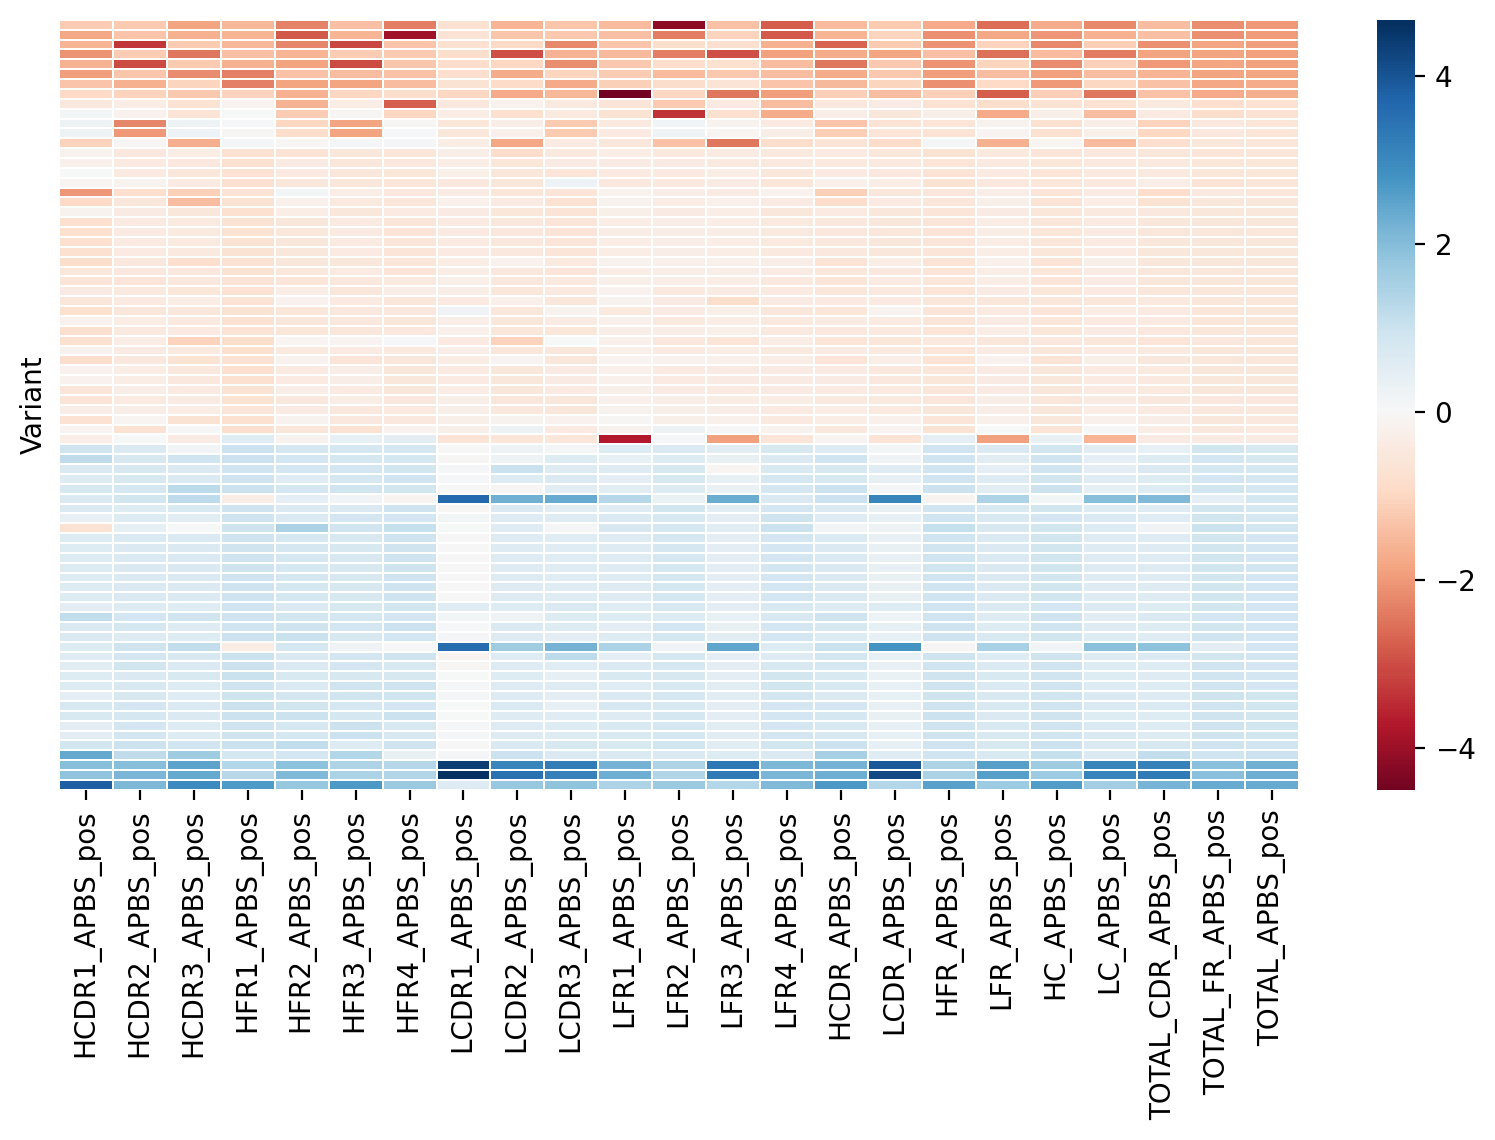

In [27]:
from sklearn.preprocessing import StandardScaler
pos_cols = [col for col in descriptors_df.columns if 'pos' in col]
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(descriptors_df), columns=descriptors_df.columns, index=descriptors_df.index)
_, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap( scaled_df[pos_cols].sort_values('TOTAL_APBS_pos'), cmap='RdBu',  center = 0,  linewidths=0.01, ax = ax)
ax.set_yticklabels([])
ax.set_yticks([])

### Combine the two data sources into one dataframe and save. 

In [35]:
print((metadata['RRT'].index ==descriptors_df.index).all())
descriptors_df['RRT'] = metadata['RRT']

True


In [36]:
data_path

PosixPath('/Users/ChristopherRivera/Documents/DataResults/MPK190')

In [62]:
# load the previously calculated descriptors
fname = data_path/'MPK190_descriptors_V13_heparin_column.pq'
previous_descriptors_df = pd.read_parquet(fname)

previous_metadata = data_path/'MPK190-v13.csv'
previous_metadata = (pd.read_csv(previous_metadata )
                     .fillna('')
                     .set_index('Name')
                     )
hic2 = previous_metadata['Hep RTT']

previous_descriptors = pd.concat([previous_descriptors_df,hic2], axis=1)

In [66]:
hic2.loc['VIRMAB-ML-M190-R2-048']== previous_descriptors.loc['VIRMAB-ML-M190-R2-048']['Hep RTT']

True

### combine the two datasets 

In [79]:
descriptors_df = descriptors_df.rename(columns={'RRT':'Hep RTT'})
combined_descriptors = (pd.concat([descriptors_df, previous_descriptors], axis=0)
                        .sort_index()
                        .dropna(subset=['Hep RTT'])
                        )

remove = combined_descriptors['Hep RTT']==''
combined_descriptors = combined_descriptors.loc[~remove]


In [81]:
### save the data
save_dir = data_path/'Datasets'
if not save_dir.exists(): 
    save_dir.mkdir()
combined_descriptors.to_parquet(save_dir/'MPK190_descriptors_heparin_column_01-05-2024.pq')

In [83]:
combined_descriptors.head()

,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net,Hep RTT
VIRMAB-ML-M190-R2-006,1281.180789,0.0,1281.180789,14818.741775,0.0,14818.741775,1593.361143,-1584.966209,8.394934,17233.406264,-32.967187,17200.439077,5548.353209,0.0,5548.353209,19138.969855,-13.511229,19125.458627,6072.687820,0.0,6072.687820,3428.153585,-2093.149201,1335.004384,0.000000,-3319.153968,-3319.153968,5557.112402,-14.817288,5542.295114,9301.686545,-700.283375,8601.403170,5347.090564,-302.265266,5044.825299,2286.916620,-5587.898765,-3300.982145,505.558478,-2576.416165,-2070.857686,17693.283707,-1584.966209,16108.317498,8985.265987,-5427.120457,3558.145530,47993.417149,-46.478416,47946.938733,17441.252208,-9166.863570,8274.388638,65686.700856,-1631.444625,64055.256231,26426.518195,-14593.984027,11832.534169,26678.549695,-7012.086666,19666.463029,65434.669357,-9213.341986,56221.327371,92113.219051,-16225.428651,75887.790400,1.046
VIRMAB-ML-M190-R2-018,2203.952198,0.0,2203.952198,16469.556834,0.0,16469.556834,3522.823932,-570.352914,2952.471018,21069.179726,0.000000,21069.179726,6507.223939,0.0,6507.223939,21367.003801,0.000000,21367.003801,7196.457751,0.0,7196.457751,4148.575187,-1178.371453,2970.203734,2874.195911,-708.406621,2165.789290,5875.287478,0.000000,5875.287478,11680.560677,-375.931801,11304.628875,7870.537144,0.000000,7870.537144,6677.933067,-2512.664338,4165.268729,863.394367,-1957.869564,-1094.475196,22196.332965,-570.352914,21625.980051,12898.058576,-1886.778075,11011.280502,56139.865216,0.000000,56139.865216,27092.425255,-4846.465703,22245.959551,78336.198181,-570.352914,77765.845267,39990.483831,-6733.243778,33257.240053,35094.391541,-2457.130988,32637.260553,83232.290471,-4846.465703,78385.824768,118326.682012,-7303.596692,111023.085320,1.004
VIRMAB-ML-M190-R2-019,1703.303380,0.0,1703.303380,15681.351429,0.0,15681.351429,2669.522759,-833.813434,1835.709325,18765.649358,-20.877461,18744.771898,5820.908440,0.0,5820.908440,20073.523757,0.000000,20073.523757,6667.895962,0.0,6667.895962,3892.477425,-1142.781316,2749.696109,1682.045107,-1138.279092,543.766015,5645.989830,0.000000,5645.989830,10288.546436,-568.018294,9720.528141,6546.599430,-38.168406,6508.431024,3597.959694,-4429.672306,-831.712612,655.685201,-2321.756992,-1666.071792,20054.177568,-833.813434,19220.364134,11220.512362,-2281.060408,8939.451954,51327.977518,-20.877461,51307.100058,21088.790760,-7357.615999,13731.174761,71382.155086,-854.690895,70527.464191,32309.303123,-9638.676407,22670.626715,31274.689930,-3114.873843,28159.816087,72416.768278,-7378.493459,65038.274819,103691.458208,-10493.367302,93198.090906,0.978
VIRMAB-ML-M190-R2-020,1271.975896,0.0,1271.975896,14573.418513,0.0,14573.418513,1534.036556,-1648.079830,-114.043274,17095.374682,-44.739920,17050.634762,5465.582006,0.0,5465.582006,18916.900945,-7.729113,18909.171831,6278.110157,0.0,6278.110157,3532.696799,-2005.044201,1527.652598,0.000000,-3163.963173,-3163.963173,5208.846066,-40.147359,5168.698707,9259.809687,-689.788936,8570.020750,5330.712477,-234.210061,5096.502416,2306.201163,-5503.2519

### Remarks: 
Now off to train. 